In [41]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy import special

In [42]:
def gen():
    return int(np.random.random() * 10**6)

# 1

In [43]:
n = 10**2
q = 0.95
np.random.seed(42)

sample_uniform = np.sort(np.random.uniform(-np.sqrt(3), np.sqrt(3), n))
sample_normal = np.sort(np.random.normal(0, 1, n))
sample_exponential = np.sort(stats.expon(scale=1, loc=-1).rvs(size=n, random_state=gen()))

In [101]:
def generator_uniform(n):
    return np.sort(np.random.uniform(-np.sqrt(3), np.sqrt(3), n))

def generator_normal(n):
    return np.sort(np.random.normal(0, 1, n))

def generator_exponential(n):
    return np.sort(stats.expon(scale=1, loc=-1).rvs(size=n, random_state=gen()))

In [45]:
def get_consider_prob(generator, interval, N=10**3):
    count_good = 0
    for _ in range(N):
        sample = generator()
        count_good += int(interval[0] <= sample.mean() <= interval[1])

    return count_good / N

In [46]:
def search_bounds(sample, generator): # sample is sorted!!!
    m = np.mean(sample)
    k_q = np.sqrt(
        (-1) * np.log((1 - q) / 2) / (2 * n) - 1 / (6 * n)
    )

    p_s = []
    for r in np.arange(0, n // 2):
        a, b = sample[r], sample[n - r - 1]
        hora_interval = (
            m - (b - a) * k_q, m + (b - a) * k_q
        )

        p = get_consider_prob(generator, hora_interval)
        p_s.append(p)

    return p_s

In [50]:
probs_uniform     = search_bounds(sample_uniform, generator_uniform)
probs_normal      = search_bounds(sample_normal, generator_normal)
probs_exponential = search_bounds(sample_exponential, generator_exponential)

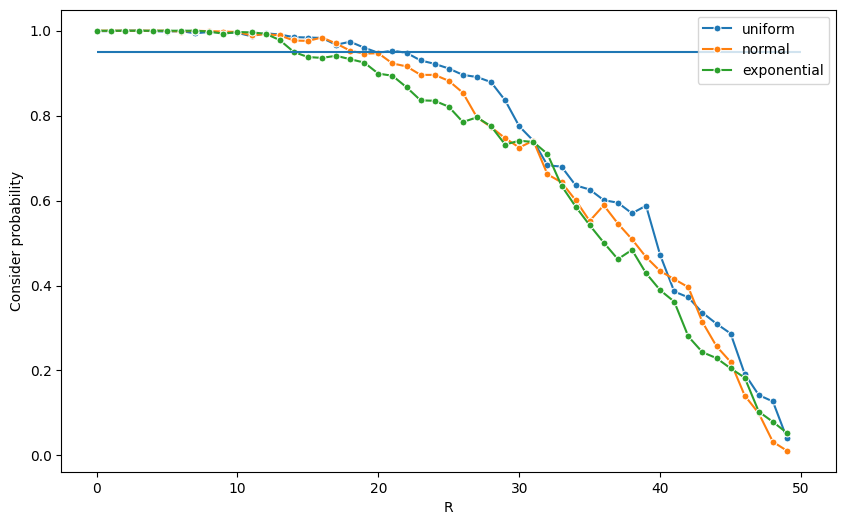

In [55]:
data_1 = pd.DataFrame({'x': np.arange(0, n // 2), 'y': probs_uniform})
data_2 = pd.DataFrame({'x': np.arange(0, n // 2), 'y': probs_normal})
data_3 = pd.DataFrame({'x': np.arange(0, n // 2), 'y': probs_exponential})

plt.figure(figsize=(10, 6))
sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='uniform')
sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='normal')
sns.lineplot(data=data_3, x='x', y='y', marker='o', markersize=5, label='exponential')
plt.hlines(y=q, xmin=0, xmax=n//2)
plt.xlabel("R")
plt.ylabel("Consider probability")
plt.show();

# 2

In [122]:
def get_consider_prob_(generator, interval, N=10**3):
    count_good = 0
    for _ in range(N):
        sample = generator(N)
        count_good += int(interval[0] <= np.quantile(sample, 0.5) <= interval[1])

    return count_good / N

In [137]:
np.unique(np.random.randint(0, n, size=n)).shape

((68,), 100)

In [138]:
def bootstrap_quantile_estimation(sample, p = 0.5, N=10**3):
    n = sample.shape[0]
    sub_quantiles = []
    for _ in range(N):
        bag_indices = np.random.randint(0, n, size=n)
        sub_sample = sample[bag_indices]

        sub_quantiles.append(np.quantile(sub_sample, p, method='nearest'))

    sub_quantiles = np.array(sub_quantiles)

    res_interval = np.array([
        np.quantile(sub_quantiles, 2.5 / 100, method='nearest'),
        np.quantile(sub_quantiles, 97.5 / 100, method='nearest')
    ])

    if not (
        res_interval[0] <= 0 <= res_interval[1]
    ): print("not in interval!!!")
    return res_interval

0.025

In [128]:
def collect_bootstrap_info(generator, p, n_arange=[10, 50, 100, 500, 1000, 3000]):
    consider_probs, widths = [], []
    for n_ in n_arange:
        sample = generator(n_)
        interval = bootstrap_quantile_estimation(sample, p)

        consider_prob = get_consider_prob_(generator, interval)
        width = abs(interval[1] - interval[0])

        consider_probs.append(consider_prob)
        widths.append(width)

    return consider_probs, widths

In [131]:
consider_probs_uniform, widths_uniform = collect_bootstrap_info(generator_uniform, 0.5)
consider_probs_normal, widths_normal = collect_bootstrap_info(generator_normal, 0.5)
# consider_probs_exponential, widths_exponential = collect_bootstrap_info(generator_exponential, 0.5)

In [119]:
consider_probs_uniform

[1.0, 1.0, 1.0, 0.516, 0.971, 0.659]

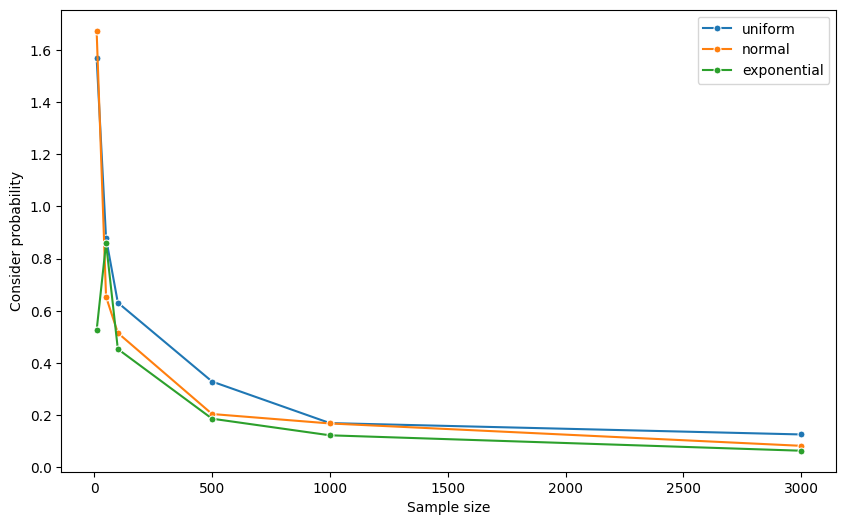

In [140]:
# data_1 = pd.DataFrame({'x': np.array([10, 50, 100, 500, 1000, 3000], dtype=float), 'y': consider_probs_uniform})
# data_2 = pd.DataFrame({'x': np.array([10, 50, 100, 500, 1000, 3000], dtype=float), 'y': consider_probs_normal})
# data_3 = pd.DataFrame({'x': np.array([10, 50, 100, 500, 1000, 3000], dtype=float), 'y': consider_probs_exponential})

data_1 = pd.DataFrame({'x': np.array([10, 50, 100, 500, 1000, 3000], dtype=float), 'y': widths_uniform})
data_2 = pd.DataFrame({'x': np.array([10, 50, 100, 500, 1000, 3000], dtype=float), 'y': widths_normal})
data_3 = pd.DataFrame({'x': np.array([10, 50, 100, 500, 1000, 3000], dtype=float), 'y': widths_exponential})


plt.figure(figsize=(10, 6))
sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='uniform')
sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='normal')
sns.lineplot(data=data_3, x='x', y='y', marker='o', markersize=5, label='exponential')
plt.xlabel("Sample size")
plt.ylabel("Consider probability")
plt.show();